# BDII, Grafos, Neo4j

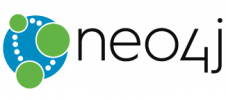

Esta hoja muestra cómo acceder a bases de datos Neo4j y también a conectar la salida con Google Colab/Jupyter.


In [1]:
RunningInCOLAB: bool = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

In [2]:
!sudo apt update -qq
!sudo apt install -qq -y apt-transport-https ca-certificates curl software-properties-common

35 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
ca-certificates is already the newest version (20240203~22.04.1).
curl is already the newest version (7.81.0-1ubuntu1.20).
software-properties-common is already the newest version (0.99.22.9).
The following NEW packages will be installed:
  apt-transport-https
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,510 B of archives.
After this operation, 170 kB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf:

In [3]:
%%capture URL_output
if RunningInCOLAB:
    !curl -fsSL https://debian.neo4j.com/neotechnology.gpg.key | sudo apt-key add -
    !sudo add-apt-repository -y "deb https://debian.neo4j.com stable latest"
    !sudo apt install --reinstall -qq neo4j
    !grep -q -e '^# Updated' /etc/neo4j/neo4j.conf || \
      sudo sed -i -e '1s/^/db.import.csv.legacy_quote_escaping=false\n/;1s/^/dbms.security.auth_enabled=false\n/;1s/^/server.memory.heap.initial_size=8G\n/;1s/^/server.memory.heap.max_size=8G\n/;1s/^/# Updated config\n/' /etc/neo4j/neo4j.conf
    !head /etc/neo4j/neo4j.config
    !sudo neo4j start
    !wget http://dsevilla-proxy.inf.um.es/frp-neo4j -qq -O frpc.ini
    !wget -qq "https://github.com/fatedier/frp/releases/download/v0.52.3/frp_0.52.3_linux_amd64.tar.gz"
    !tar zxf frp_*
    !./frp_0.*/frpc -c frpc.ini >/dev/null 2>&1 &
    !grep ^remote_port frpc.ini | sed -e '1s/remote_port = /http:\/\/dsevilla-proxy.inf.um.es:/;2s/remote_port = /bolt:\/\/dsevilla-proxy.inf.um.es:/'

In [4]:
if RunningInCOLAB:
    print(URL_output)

OK
Repository: 'deb https://debian.neo4j.com stable latest'
Description:
Archive for codename: stable components: latest
More info: https://debian.neo4j.com
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/archive_uri-https_debian_neo4j_com-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/archive_uri-https_debian_neo4j_com-jammy.list
Get:1 https://debian.neo4j.com stable InRelease [44.2 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://debian.neo4j.com stable/latest amd64 Packages [1,522 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadc

In [5]:
import os
BOLT_URL: str = f"bolt://{os.getenv('DB_HOSTNAME', 'localhost')}:7687"
if RunningInCOLAB:
    BOLT_URL = URL_output.stdout.split(os.linesep)[-2]
    HTTP_URL: str = URL_output.stdout.split(os.linesep)[-3]
    print(f"URL de conexión al interfaz Web:\n{HTTP_URL}")

print(f"URL de conexión de BOLT:\n{BOLT_URL}")

URL de conexión al interfaz Web:
http://dsevilla-proxy.inf.um.es:8138
URL de conexión de BOLT:
bolt://dsevilla-proxy.inf.um.es:8139


In [6]:
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

In [7]:
%pip install neo4j-driver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.5/312.5 kB 6.7 MB/s eta 0:00:00


Conexión a la Base de Datos


In [8]:
from neo4j import GraphDatabase, Driver, Session, Result, basic_auth

driver: Driver = GraphDatabase.driver(
    BOLT_URL,
    auth=basic_auth("neo4j", ""))
session: Session = driver.session()

cypher_query = '''
MATCH (n)
RETURN n AS id
LIMIT 10
'''

results: Result = session.run(cypher_query,  parameters={})

for record in results:
  print(record['id'])

La siguiente celda genera una consulta en Cypher que devuelve los 10 primeros nodos. Al inicio la base de datos está vacía, pero se puede probar después para ver la salida. Existen plugins para ver gráficamente la salida como un grafo, pero para eso usaremos el interfaz gráfico del propio Neo4j.

In [9]:
query = '''
MATCH (n)
RETURN n
LIMIT 10
'''

with driver.session() as session:
  results: Result = session.run(query)
  for record in results:
    print(record)

La siguiente función hace de `contextmanager` (un objeto que permite definir recursos dentro de un bloque `with`) para poder ejecutar consultas en la base de datos usando una nueva sesión:

In [10]:
from collections.abc import Generator
from contextlib import contextmanager

@contextmanager
def run_query(query: str) -> Generator[Result, None, None]:
  with driver.session() as session:
    yield session.run(query)

La carga de datos CSV no se podía realizar directamente desde los ficheros CSV la hoja, porque el CSV que acepta Neo4j no es estándar. Envié un *issue* para que lo arreglaran, y en la versión 3.3 parece que ya funciona si se añade un parámetro de configuración: https://github.com/neo4j/neo4j/issues/8472

```bash
db.import.csv.legacy_quote_escaping = false
```

He añadido al contenedor de la práctica esta opción en la carga de Neo4j. Tened en cuenta que si usáis otra configuración hay que añadírselo.

Primero se crea un índice sobre el atributo `Id` de `User`, que se usará después para crear usuarios y relacionarlos con la pregunta o respuesta que se ha leído. Si no se hace esto, la carga del CSV es muy lenta.

In [11]:
with run_query("CREATE INDEX IF NOT EXISTS FOR (u:User) ON (u.Id);") as _:
    ...

El siguiente código carga el CSV de las preguntas y respuestas. El código primero todos los nodos con la etiqueta `Post`, y después añade la etiqueta `Question` ó `Answer` dependiendo del valor del atributo `PostTypeId`.

In [12]:
%%sh
(wget -qq https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.tar.xz.00 -O -;
 wget -qq https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.tar.xz.01 -O -) |\
     tar Jxvf -

Comments.csv
Posts.csv
Tags.csv
Users.csv
Votes.csv


### El lenguaje Cypher

El lenguaje Cypher tiene una sintaxis de _Query By Example_. Acepta funciones y permite creación y búsqueda de nodos y relaciones. Tiene algunas peculiaridades que veremos a continuación. Por lo pronto, se puede ver un resumen de características en la [Cypher Reference Card](https://neo4j.com/docs/cypher-refcard/current/).

La siguiente consulta utiliza la construcción `LOAD CSV` para leer datos CSV dentro de nodos. La cláusula `CREATE` crea nuevos nodos. La `SET` permite poner valores a las propiedades de los nodos.

En el caso de la consulta de siguiente, a todos los datos leídos se les copia los datos de la línea (primer `SET`). Después, dependiendo del valor de `PostTypeId`, se les etiqueta como `:Question` o como `:Answer`. Si tienen un usuario asignado a través de `OwnerUserId`, se añade un usuario, si el usuario no existe ya, y se crea la relación `:WROTE`.

También hay otros posts especiales que no eran preguntas ni respuestas. A estos no se les asigna una segunda etiqueta:

In [13]:
if RunningInCOLAB:
    !sudo ln Posts.csv /var/lib/neo4j/import/
else:
    !test -e /tmp/neo4j_import || mkdir /tmp/neo4j_import
    !sudo cp Posts.csv /tmp/neo4j_import/

In [14]:
with run_query(
        '''
        LOAD CSV WITH HEADERS from "file:///Posts.csv" AS row
        CALL (row) {
            CREATE (n)
            SET n = row
            SET n :Post
        } IN TRANSACTIONS OF 10000 ROWS
        ;
        '''
        ) as result:
    print(result.consume().counters)

{'_contains_updates': True, 'labels_added': 410346, 'nodes_created': 410346, 'properties_set': 9027094}


### OJO:
Para borrar la base de datos entera, por si se cometen errores:

    query = "CALL { MATCH (n) DETACH DELETE n } IN TRANSACTIONS OF 10000 ROWS"
    run_query(query)

In [67]:
def clear_database() -> None:
  """
  Eliminar la base de datos completamente.
  """
  query = "CALL { MATCH (n) DETACH DELETE n } IN TRANSACTIONS OF 10000 ROWS"
  with run_query(query) as _:
   ...

A todas las preguntas, se las etiqueta con `Question`.

In [68]:
with run_query('''
      MATCH (n:Post {PostTypeId : "1"})
        SET n:Question;
      ''') as result:
    print(result.consume().counters)

{}


A todas las respuestas se las etiqueta con `Answer`.

In [69]:
with run_query('''
      MATCH (n:Post {PostTypeId : "2"})
        SET n:Answer;
      ''') as result:
    print(result.consume().counters)

{}


Se crea un nodo usuario (o se utiliza uno si ya existe) usando el campo `OwnerUserId`, siempre que no esté vacío. Nótese que se puede utilizar `CREATE` porque esta combinación de relación usuario y pregunta no existe. Cuidado, si se ejecuta dos veces creará el doble de relaciones. Se aprovecha para añadir una característica a la propia relación, la fecha de creación de la pregunta por parte del usuario.

In [70]:
with run_query('''
        MATCH (n:Post)
        WHERE n.OwnerUserId <> ""
            MERGE (u:User {Id: n.OwnerUserId})
            CREATE (u)-[:WROTE {CreationDate: n.CreationDate}]->(n);
        ''') as result:
    pp(result.consume().counters)

{'_contains_updates': True, 'relationships_created': 403879, 'properties_set': 403879}


In [71]:
with run_query('''
        match r=(u:User)-[:WROTE]->(p:Post) RETURN r LIMIT 20
''') as result:
  for record in result:
    pp(record)

<Record r=<Path start=<Node element_id='4:29a2e73c-7675-41eb-86d4-da115bd4e36f:410346' labels=frozenset({'User'}) properties={'CreationDate': neo4j.time.DateTime(2015, 10, 29, 14, 53, 36, 233000000, tzinfo=<UTC>), 'DisplayName': 'Konamiman', 'Id': '23', 'Reputation': 5278, 'Location': 'Palma de Mallorca, Spain'}> end=<Node element_id='4:29a2e73c-7675-41eb-86d4-da115bd4e36f:0' labels=frozenset({'Post', 'Question'}) properties={'CreationDate': '2015-10-29T15:56:52.933', 'ViewCount': '780', 'Title': 'La creación manual de un alias de ruta con un DirectRouteProvider personalizado causa un error "Multiple actions were found that match the request"', 'LastEditorDisplayName': 'user13558', 'ContentLicense': 'CC BY-SA 4.0', 'OwnerUserId': '23', 'Score': '40', 'LastActivityDate': '2021-03-12T17:49:40.687', 'AnswerCount': '1', 'CommentCount': '2', 'LastEditDate': '2019-07-07T21:36:17.737', 'PostTypeId': '1', 'Id': '1', 'AcceptedAnswerId': '2', 'Body': '<p>Estoy creando un servicio usando <em>ASP.

Creamos un índice sobre el `Id` para acelerar las siguientes búsquedas:

In [72]:
with run_query("CREATE INDEX IF NOT EXISTS FOR (n:Post) ON (n.Id);") as _:
   ...

Añadimos una relación entre las preguntas y las respuestas:

In [73]:
with run_query('''
        MATCH (a:Answer), (q:Question {Id: a.ParentId})
        CREATE (a)-[:ANSWERS]->(q)
        ''') as result:
    pp(result.consume().counters)

{'_contains_updates': True, 'relationships_created': 211615}


Las construcciones `%cypher` retornan resultados de los que se puede obtener un `dataframe` de `pandas`:

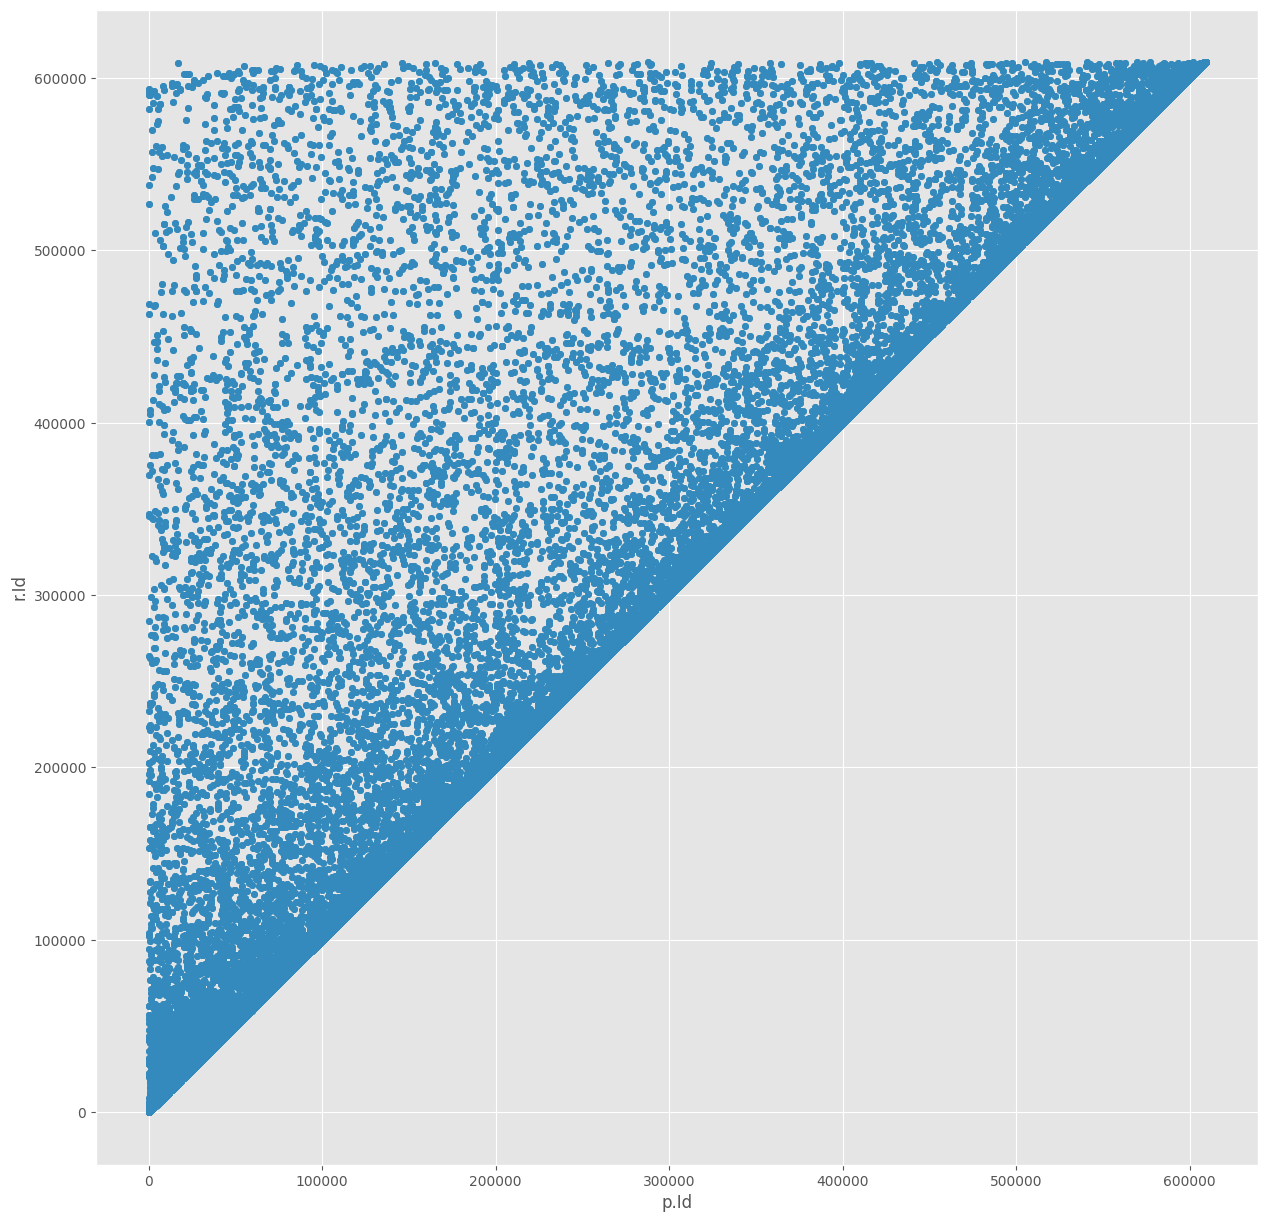

In [74]:
with run_query("MATCH q=(r)-[:ANSWERS]->(p) RETURN p.Id,r.Id;") as res:
  df = pd.DataFrame([r.values() for r in res], columns=res.keys())
  df['r.Id'] = pd.to_numeric(df['r.Id'],downcast='unsigned')
  df['p.Id'] = pd.to_numeric(df['p.Id'],downcast='unsigned')

  df.plot(kind='scatter',x='p.Id',y='r.Id',figsize=(15,15))

La consulta de reciprocidad entre usuarios de Stackoverflow se puede resolver de manera muy fácil. En esta primera consulta se devuelve los nodos:

In [75]:
with run_query('''// RQ4
    MATCH
    (u1:User)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u2:User),
    (u2)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u1)
    WHERE u1 <> u2 AND u1.Id < u2.Id
    RETURN DISTINCT u1,u2
    ''') as res:
  for r in res:
    print(r['u1'], r['u2'])

KeyboardInterrupt: 

O bien retornar los `Id` de cada usuario:

In [76]:
with run_query('''// RQ4
    MATCH
    (u1:User)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u2:User),
    (u2)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u1)
    WHERE u1 <> u2 AND toInteger(u1.Id) < toInteger(u2.Id)
    RETURN DISTINCT u1.Id,u2.Id
    ORDER BY toInteger(u1.Id)
    ''') as res:
  for r in res:
    print(r['u1.Id'], r['u2.Id'])

ServiceUnavailable: Couldn't connect to dsevilla-proxy.inf.um.es:8139 (resolved to ('155.54.204.149:8139',)):
Connection to 155.54.204.149:8139 closed with incomplete handshake response

Y finalmente, la creación de relaciones `:RECIPROCATE` entre los usuarios. Se introduce también la construcción `WITH`.

`WITH` sirve para introducir "espacios de nombres". Permite importar nombres de filas anteriores, hacer alias con `AS` e introducir nuevos valores con funciones de Cypher. La siguiente consulta es la misma de arriba, RQ4, pero creando relaciones `:RECIPROCATE` entre cada dos usuarios que se ayudan recíprocamente.

In [ ]:
with run_query('''
    // RQ4 creando relaciones de reciprocidad
    MATCH
      (u1:User)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u2:User),
      (u2)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u1)
    WHERE u1 <> u2 AND u1.Id < u2.Id
    WITH u1 AS user1,u2 AS user2
      MERGE (user1)-[:RECIPROCATE]->(user2)
      MERGE (user2)-[:RECIPROCATE]->(user1)
    ''') as res:
  for r in res:
    print(r)

También se puede buscar el camino mínimo entre dos usuarios cualesquiera. Si existe un camino a través de alguna pregunta o respuesta, la encontrará. Un ejemplo donde hay una comunicación directa:

In [ ]:
with run_query("MATCH p=shortestPath( (u1:User {Id: '24'})-[*]-(u2:User {Id:'25'}) ) RETURN p") as res:
  for r in res:
    print(r['p'])

Mientras que con otro usuario la cadena es más larga:

In [ ]:
with run_query("MATCH p=shortestPath( (u1:User {Id: '324'})-[*]-(u2:User {Id:'25'}) ) RETURN p") as res:
  for r in res:
    print(r['p'])

Finalmente se pueden encontrar todos los caminos mínimos en donde se ve que tiene que existir al menos un par pregunta/respuesta entre los usuarios que son recíprocos:

In [ ]:
with run_query("MATCH p=allShortestPaths( (u1:User {Id: '24'})-[*]-(u2:User {Id:'25'}) ) RETURN p") as res:
  for r in res:
    print(r['p'])

## EJERCICIO: Construir los nodos `:Tag` para cada uno de los tags que aparecen en las preguntas. Construir las relaciones `post-[:TAGGED_BY]->tag` para cada tag y también `tag-[:TAGS]->post`

(**OJO**: Hay que crear un índice antes para `Tag.name`, si no el proceso es muy lento)


In [ ]:
with run_query("CREATE INDEX IF NOT EXISTS FOR (t:Tag) ON (t.name);") as _:
   ...

In [ ]:
with run_query('''
    MATCH (q: Question)
    WHERE q.Tags <> ""
      WITH q, replace(replace(q.Tags, "><", ","), "<", "") AS step1
      WITH q, replace(step1, ">", "") AS cleaned
      WITH q, split(cleaned,",") AS list
      UNWIND list AS tag
      MERGE (t:Tag {name: tag})
      MERGE (q)-[:TAGGED_BY]->(t)
      MERGE (t)-[:TAGS]->(q)
    ''') as result:
  print(result.consume().counters)

Para ello, buscar en la ayuda las construcciones `WITH` y `UNWIND` y las funciones `replace()` y `split()` de Cypher. La siguiente consulta debe retornar `26135` resultados:

In [ ]:
with run_query('''
    MATCH p=(t:Tag)-[:TAGS]->(:Question) WHERE t.name =~ "^java$|^c\\\\+\\\\+$" RETURN count(p);
''') as res:
  for r in res:
    print(r)

La siguiente consulta muestra los usuarios que preguntan por cada Tag:

In [ ]:
with run_query("MATCH (t:Tag)-->(:Question)<--(u:User) RETURN t.name,collect(distinct u.Id) ORDER BY t.name;") as res:
  for r in res:
    print(r)

El mismo `MATCH` se puede usar para encontrar qué conjunto de tags ha usado cada usuario cambiando lo que retornamos:

In [ ]:
with run_query("MATCH (t:Tag)-->(:Question)<--(u:User) RETURN u.Id, collect(distinct t.name) ORDER BY toInteger(u.Id) LIMIT 100;") as res:
  for r in res:
    print(r)

## EJERCICIO: Relacionar cada usuario con los tags de sus preguntas a través de la relación `:INTERESTED_IN`.

In [ ]:
with run_query('''
    MATCH (u:User)-->(q:Question)-->(t:Tag)
    MERGE (u)-[:INTERESTED_IN]->(t)
''') as res:
    print(res.consume().counters)


Con la solución correcta, la siguiente consulta debe dar el resultado de 10166.

In [ ]:
query='''MATCH (u:User)-[:INTERESTED_IN]->(t:Tag {name: 'java'})
 RETURN count(u)
 '''
with run_query(query) as res:
  for r in res:
    print(r)

## EJERCICIO: Cargar el CSV de Users y añadir las propiedades faltantes a los usuarios (hasta ahora cada nodo `:User` sólo tiene la propiedad `Id`. Hay que cargar el resto a partir del CSV).

In [ ]:
if RunningInCOLAB:
    !sudo ln Users.csv /var/lib/neo4j/import/
else:
    !test -e /tmp/neo4j_import || mkdir /tmp/neo4j_import
    !sudo cp Users.csv /tmp/neo4j_import/

In [ ]:
with run_query(
    '''
    LOAD CSV WITH HEADERS FROM "file:///Users.csv" AS row
    MATCH (u:User {Id: row.Id})
    WHERE row.Reputation IS NOT NULL AND row.Reputation <> ""
    SET u.Reputation = toInteger(row.Reputation),
        u.DisplayName = CASE WHEN row.DisplayName <> "" THEN row.DisplayName ELSE u.DisplayName END,
        u.Location = CASE WHEN row.Location <> "" THEN row.Location ELSE u.Location END,
        u.CreationDate = CASE WHEN row.CreationDate <> "" THEN datetime(row.CreationDate) ELSE u.CreationDate END
    '''
) as result:
    print(result.consume().counters)


Si la importación fue correcta, se puede acceder a la media de puntuación de los usuarios, cuyo valor debe ser: "`avg(rep)=21.546268796845204 max(rep)=109420 min(rep)=1`".

In [ ]:
query='''MATCH (u:User)
 WITH toInteger(u.Reputation) AS rep
 RETURN avg(rep), max(rep), min(rep)
 '''
with run_query(query) as res:
  for r in res:
    print(r)